# CNN으로 패션 아이템 구분하기
- 흑백 이미지
- from Pytorch official Documentation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
EPOCHS     = 40
BATCH_SIZE = 64

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # 입력채널수(흑백이므로 1), 출력채널수, 커널사이즈
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # input, 커널크기
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # 2차원을 1차원으로 펴주기(차원 축소, 나머지 차원은 모두 -1에)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [7]:
model     = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [8]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327074
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.304774
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.518547
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.639790
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.553578
[1] Test Loss: 0.2035, Accuracy: 93.88%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.583562
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.498570
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.317146
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.367570
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.330507
[2] Test Loss: 0.1260, Accuracy: 96.06%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.534283
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.356768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.164879
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.300566
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.241633
[3] Test Loss: 0.0996, Accuracy: 96.84%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.297092
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.479451
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.222132


Train Epoch: 29 [38400/60000 (64%)]	Loss: 0.266177
Train Epoch: 29 [51200/60000 (85%)]	Loss: 0.078930
[29] Test Loss: 0.0342, Accuracy: 98.88%
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.136740
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.110551
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.096758
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.050359
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.135727
[30] Test Loss: 0.0340, Accuracy: 98.93%
Train Epoch: 31 [0/60000 (0%)]	Loss: 0.139015
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.102659
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.109909
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.121773
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.064748
[31] Test Loss: 0.0365, Accuracy: 98.84%
Train Epoch: 32 [0/60000 (0%)]	Loss: 0.103884
Train Epoch: 32 [12800/60000 (21%)]	Loss: 0.132301
Train Epoch: 32 [25600/60000 (43%)]	Loss: 0.061583
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.097075
Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.066446
[32] Test Loss: 0.0329, A

# ResNet 활용

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [12]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [13]:
EPOCHS     = 300
BATCH_SIZE = 128

In [14]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./.data\cifar-10-python.tar.gz to ./.data


### 배치 정규화(Batch Normalization)
- 학습률을 너무 높게 잡으면 기울기 소실 및 발산 예방 방법
- 학습 중 각 계층에 들어가는 입력을 평균과 분산으로 정규화
- !! 앞쪽 layer의 효과가 정규화되면서, 뒤에 layer에 미치는 영향이 작아짐
- 따라서, 학습속도가 증가하는 효과
- 자체적 정규화로 드랍아웃과 같은 효과(곱셉, 뺄셈 noise가 추가되어서)

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # 여러 모듈을 하나의 모듈로 묶는 역할,그대로 더해주기 위함(미리 담아두기)
        self.shortcut = nn.Sequential() 
        if stride != 1 or in_planes != planes:# 첫 layer가 아니고, input과 output이 다를 때(증폭)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # 두번째 블록부터 더해줌
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1) # 16-> 16, 16->16 블록 2개
        self.layer2 = self._make_layer(32, 2, stride=2) # 16-> 32, 32->32 블록 총 2개
        self.layer3 = self._make_layer(64, 2, stride=2) # 32-> 64, 64->64 블록 총 2개
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

- ResNet layer 구조
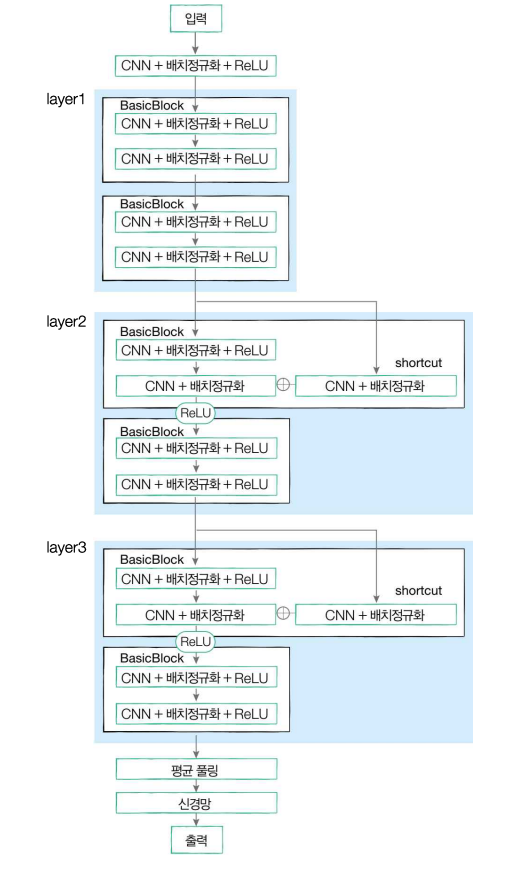

In [16]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) # 50번 호출될때, lr에 0.1을 곱함

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [18]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step() # 학습률 낮춰주는 단계 추가

In [19]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

C:\Users\autot\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1] Test Loss: 1.4722, Accuracy: 47.72%


KeyboardInterrupt: 